In [231]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

In [3]:
words, word_to_vec_map = read_glove_vecs('./glove.6B.50d.txt')

In [273]:
df = pd.read_csv('./final_new.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12742 entries, 0 to 12741
Data columns (total 2 columns):
0    12742 non-null object
1    12742 non-null int64
dtypes: int64(1), object(1)
memory usage: 199.2+ KB


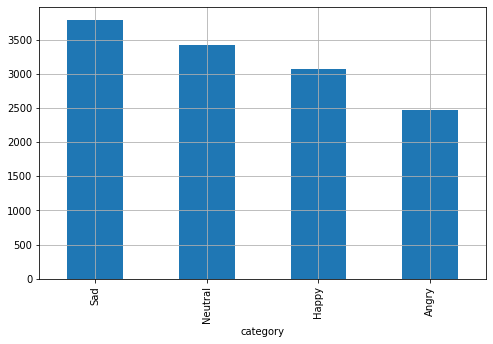

In [274]:
mapping = {
    3: 'Sad',
    0: 'Neutral',
    1: 'Happy',
    2: 'Angry'
}

def mappingToEmotion(value):
    return mapping[value]


df_count = pd.DataFrame()
# df_count['label'] = df['1'].unique()
df_count['counts'] = df['1'].value_counts()
df_count['category'] = df_count['counts'].index
df_count['category'] = df_count['category'].apply(mappingToEmotion)

df_count.plot(x='category', y='counts', kind='bar', legend=False, grid=True, figsize=(8, 5))

In [31]:
X = df['0']
y = df['1']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(y_train.unique())
print(y_train.value_counts())

(8919,)
(8919,)
[2 1 3 0]
3    2713
0    2389
1    2103
2    1714
Name: 1, dtype: int64


In [87]:
def avg_vec(sentence):
    words = sentence.lower().split()
    avg = np.zeros((50,0))
    total = 0
    
    for word in words:
        try:
            vec = word_to_vec_map[word]
        except:
            vec = word_to_vec_map['unk']
            
        total += vec
        
    avg = total/len(words)
    return avg

def check_word(sentence):
    words = sentence.lower().split()
    
    for word in words:
        try:
            vec = word_to_vec_map[word]
        except:
            print(word)

In [185]:
class AverageSentence(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        array = np.zeros((X.shape[0], 50))
        values = X.apply(avg_vec).values
        for i in range(X.shape[0]):
            array[i] = values[i]
        return array

In [209]:
SGD_clf = SGDClassifier(loss='log', penalty='l2',
                          alpha=1e-4, random_state=0,
                          max_iter=500, tol=None)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(200, 20), random_state=3)
text_clf = Pipeline([
    ('avg', AverageSentence()),
    ('clf', clf),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('avg', AverageSentence()),
                ('clf',
                 MLPClassifier(activation='relu', alpha=1e-05,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(200, 20),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=3, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [212]:
predicted = text_clf.predict(X_train)
np.mean(predicted == y_train)

0.6592667339387823